# Installing Whisper

The commands below will install the Python packages needed to use Whisper models and evaluate the transcription results.

In [56]:
! pip install -U openai-whisper
! pip install -qq https://github.com/pyannote/pyannote-audio/archive/refs/heads/develop.zip
! pip install pydub

  Preparing metadata (setup.py) ... done


In [35]:
import os
import numpy as np
import pandas as pd

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import torchaudio

import whisper
from pyannote.audio import Pipeline
from pydub import AudioSegment
import pyAudioAnalysis.audioSegmentation as seg

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Audio, display

In [3]:
def load_data(path):
      waveform, sampling_rate = torchaudio.load(path)
      metadata = torchaudio.info(path)
      print(metadata)
      return waveform, sampling_rate


def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1, figsize=(15, 5))
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1, figsize=(15, 5))
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


def segment_audio(file_path, segments):
    audio = AudioSegment.from_mp3(file_path)

    for i, segment in enumerate(segments):
        start_time = int(segment["start"] * 1000)  # Convert seconds to milliseconds
        end_time = int(segment["end"] * 1000)
        segment_audio = audio[start_time:end_time]

        segment_file_path = f"segment_{i+1}.mp3"
        segment_audio.export(segment_file_path, format="mp3")
        print(f"Segment {i+1} exported: {segment_file_path}")


def collect_segment_file_paths(directory):
    file_paths = []

    for filename in os.listdir(directory):
        if filename.startswith("segment"):
            file_path = os.path.join(directory, filename)
            file_paths.append(file_path)

    return file_paths

# Loading and analysing the audio file

The following will load the audio file using torchaudio, as well as it will plot waveform and spectrogram.

In [4]:
file_path = "test.mp3"
waveform, orig_sampling_rate = load_data(file_path)

AudioMetaData(sample_rate=48000, num_frames=2321327, num_channels=2, bits_per_sample=0, encoding=UNKNOWN)


In [5]:
target_sampling_rate = 16000
if orig_sampling_rate != target_sampling_rate:
  resampler = torchaudio.transforms.Resample(orig_sampling_rate, target_sampling_rate)
  waveform = resampler(waveform)

In [6]:
print_stats(waveform, sample_rate=target_sampling_rate)

Sample Rate: 16000
Shape: (2, 773776)
Dtype: torch.float32
 - Max:      0.665
 - Min:     -0.679
 - Mean:     0.000
 - Std Dev:  0.096

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6122e-11, 5.4013e-11,
         6.7508e-11],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6380e-11, 4.3339e-11,
         2.1945e-11]])



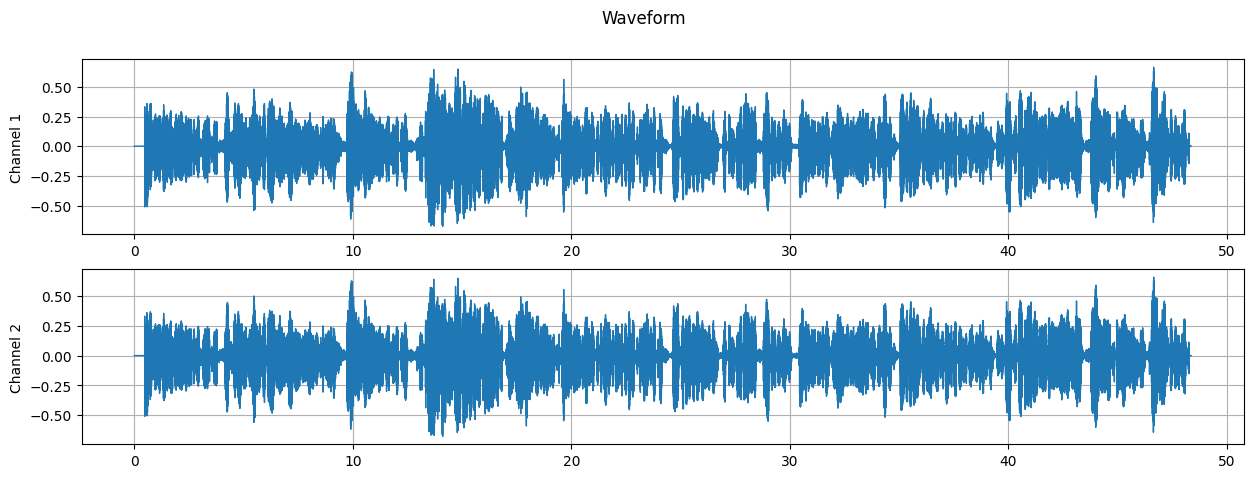

In [7]:
plot_waveform(waveform, target_sampling_rate)

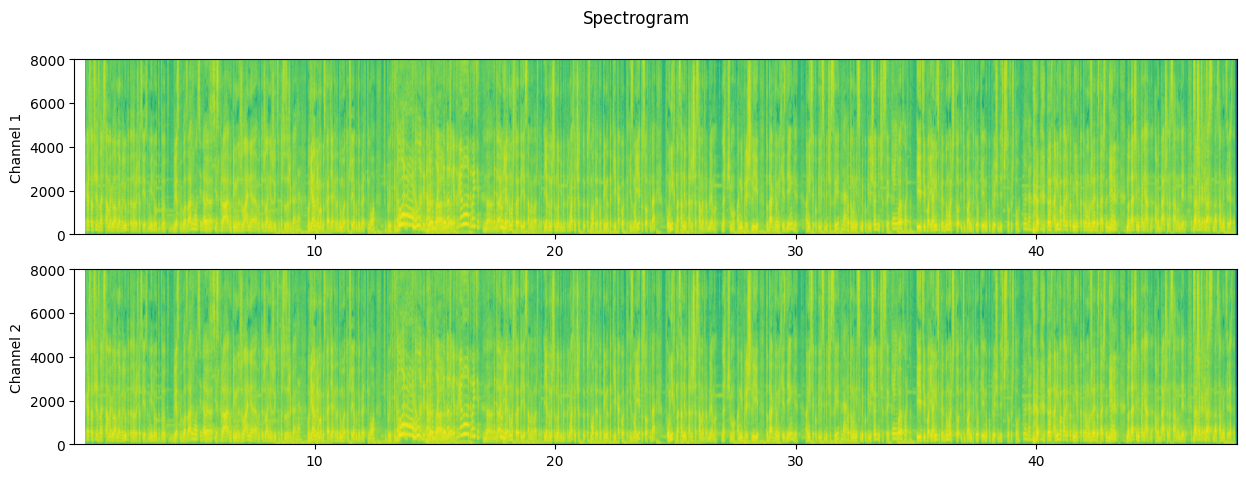

In [8]:
plot_specgram(waveform, target_sampling_rate)

In [9]:
play_audio(waveform, target_sampling_rate)

# Speaker diarization

To load the speaker diarization pipeline,

* accept the user conditions on [hf.co/pyannote/speaker-diarization](https://hf.co/pyannote/speaker-diarization)
* accept the user conditions on [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation)
* login using `notebook_login` below

In [10]:
from huggingface_hub import notebook_login
notebook_login()

In [11]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu118. Bad things might happen unless you revert torch to 1.x.


In [12]:
diarization = pipeline(file_path)

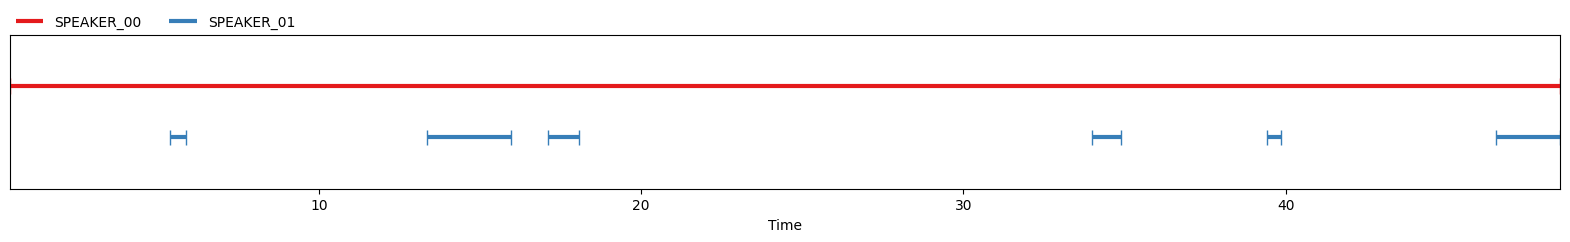

In [13]:
diarization

In [27]:
time_segments = []

for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker={speaker}")
    time_segments.append({"start": turn.start, "end": turn.end, "speaker": speaker})

start=0.4s stop=48.5s speaker=SPEAKER_00
start=5.4s stop=5.9s speaker=SPEAKER_01
start=13.4s stop=15.9s speaker=SPEAKER_01
start=17.1s stop=18.1s speaker=SPEAKER_01
start=34.0s stop=34.9s speaker=SPEAKER_01
start=39.4s stop=39.9s speaker=SPEAKER_01
start=46.5s stop=48.5s speaker=SPEAKER_01


In [28]:
segment_audio(file_path, time_segments)

Segment 1 exported: segment_1.mp3
Segment 2 exported: segment_2.mp3
Segment 3 exported: segment_3.mp3
Segment 4 exported: segment_4.mp3
Segment 5 exported: segment_5.mp3
Segment 6 exported: segment_6.mp3
Segment 7 exported: segment_7.mp3


# Running inference on the audio file using Whisper model

The following will take a few minutes to transcribe the audio file.

In [23]:
whisper_model = whisper.load_model("medium")

In [24]:
prompt_ru = "Добавь знаки препинания. Например: Привет, как дела? Привет, я в порядке."

In [26]:
file_paths = collect_segment_file_paths(".")

In [55]:
for fp, ts in zip(file_paths,time_segments):
  result = whisper_model.transcribe(
                                      audio=fp,
                                      initial_prompt=prompt_ru
                                    )
  print(f'{fp} - {ts["speaker"]}: {result["text"]}')

./segment_2.mp3 - SPEAKER_00:  Я в порядке.
./segment_5.mp3 - SPEAKER_01:  Я некомфортно.
./segment_6.mp3 - SPEAKER_01:  Ну да.
./segment_4.mp3 - SPEAKER_01:  Это круто.
./segment_7.mp3 - SPEAKER_01:  Дальше как раз самое интересное.
./segment_1.mp3 - SPEAKER_01:  Мне кажется, что самое главное валюта, которая сейчас есть в мире, это блеск в глазах, искра, желание жить, то, что зажигает. Я, например, могу сказать, когда думаю о том, что я буду играть в кино, я такой «Вау!» Ты голодный, да, в этом плане? Я тоже. Я такая «Вау!» Да, я думаю, что это самое важное. Я думаю, что многие предприниматели, кто смотрит, такие как из моей тусовки, у них на самом деле та же самая проблема. Знаешь почему? Они пришли туда, где у них есть деньги, они все купили себе часы, потом они себе купили еще одни часы. И они комфортны. И они теперь думают, что они такие «Окей, ну куплю еще 10 часов, и что?» Ну да. То есть они попали в тот мир, в котором уже достаточно денег, но дальше непонятно. А вот дальше, на